## This notebook will utilize machine learning techniques to predict future stock prices. This example will use an LSTM to predict the future price of Apple's stock.

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

### yfinance is a convenient library for downloading historical stock data through the Yahoo Finance API.

In [2]:
import yfinance as yf

In [3]:
aapl_df=yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


In [4]:
aapl_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.513393,0.515625,0.513393,0.513393,0.405683,117258400
1980-12-15,0.488839,0.488839,0.486607,0.486607,0.384517,43971200
1980-12-16,0.453125,0.453125,0.450893,0.450893,0.356296,26432000
1980-12-17,0.462054,0.464286,0.462054,0.462054,0.365115,21610400
1980-12-18,0.475446,0.477679,0.475446,0.475446,0.375698,18362400
...,...,...,...,...,...,...
2020-07-20,385.670013,394.000000,384.250000,393.429993,393.429993,22579500
2020-07-21,396.690002,397.000000,386.970001,388.000000,388.000000,25911500
2020-07-22,386.769989,391.899994,386.410004,389.089996,389.089996,22250400


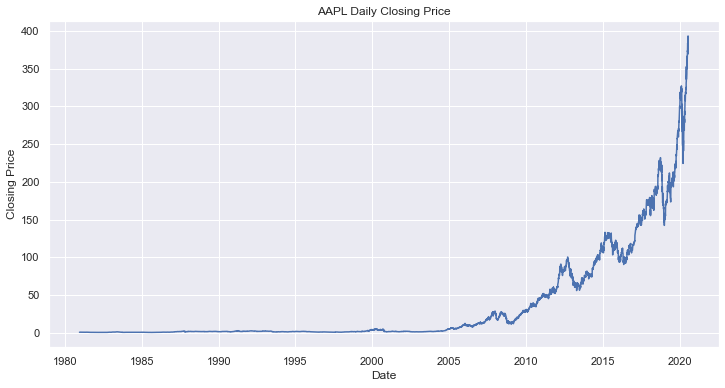

In [5]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("AAPL Daily Closing Price")
plt.show()

### Not much activity is observed in the pre-2005 data, so we will use only the data from 2005 onward.

In [6]:
aapl_df=aapl_df[aapl_df.index.year>=2005]

In [7]:
aapl_df.iloc[0,:]

Open         4.627143e+00
High         4.650714e+00
Low          4.471428e+00
Close        4.520714e+00
Adj Close    3.913571e+00
Volume       1.729980e+08
Name: 2005-01-03 00:00:00, dtype: float64

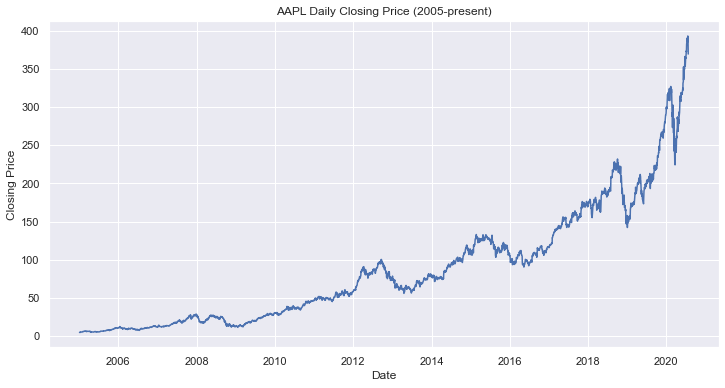

In [8]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'])
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("AAPL Daily Closing Price (2005-present)")
plt.show()

#### A quick check for possible missing data:

In [9]:
aapl_df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
aapl_df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

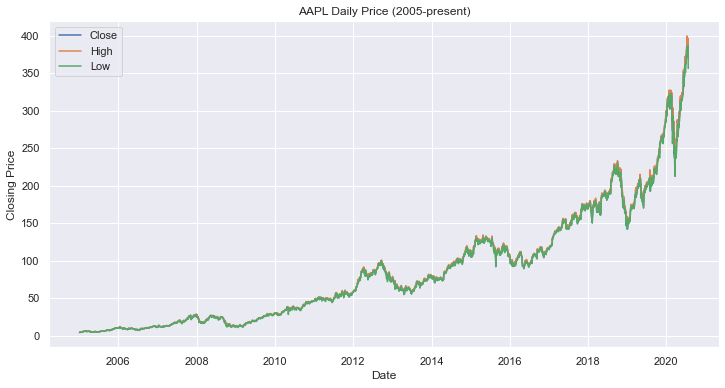

In [11]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'], label="Close")
plt.plot(aapl_df.index, aapl_df['High'], label="High")
plt.plot(aapl_df.index, aapl_df['Low'], label="Low")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("AAPL Daily Price (2005-present)")
plt.show()

## 7-day and 30-day rolling averages are calculated to help smooth out the curve, making it less erratic/jagged and short-term trends more apparent.

In [12]:
aapl_df=aapl_df.assign(sma7=aapl_df['Close'].rolling(7).mean().values)

In [13]:
aapl_df=aapl_df.assign(sma30=aapl_df['Close'].rolling(30).mean().values)

In [14]:
aapl_df[-5:]

,Open,High,Low,Close,Adj Close,Volume,sma7,sma30
Date,,,,,,,,
2020-07-20,385.670013,394.000000,384.250000,393.429993,393.429993,22579500,387.078570,364.409997
2020-07-21,396.690002,397.000000,386.970001,388.000000,388.000000,25911500,387.695714,366.227997
2020-07-22,386.769989,391.899994,386.410004,389.089996,389.089996,22250400,388.721427,367.731330
2020-07-23,387.989990,388.309998,368.040009,371.380005,371.380005,49081100,386.314283,368.349331
2020-07-24,363.950012,371.619995,356.579987,369.720001,369.720001,37354807,383.288570,369.476664


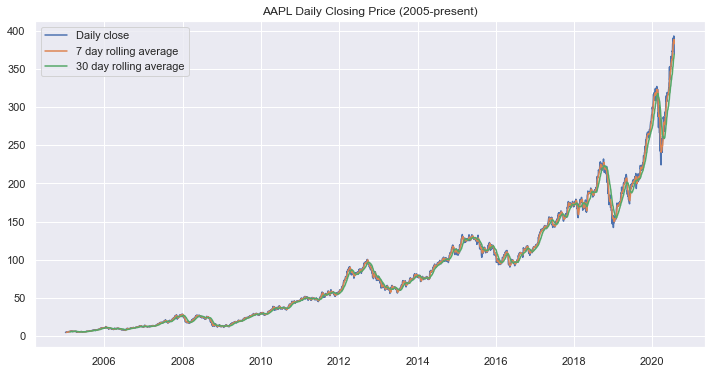

In [15]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'], label="Daily close")
plt.plot(aapl_df.index, aapl_df['sma7'], label="7 day rolling average")
plt.plot(aapl_df.index, aapl_df['sma30'], label="30 day rolling average")
plt.legend()
plt.title("AAPL Daily Closing Price (2005-present)")
plt.show()

#### A closer look at more recent prices:

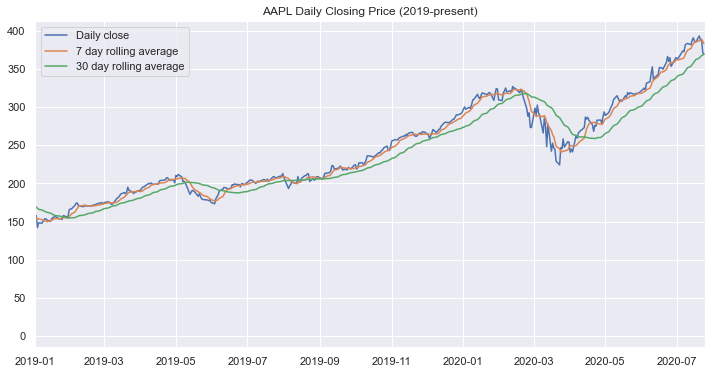

In [16]:
plt.figure(figsize=(12,6))
plt.plot(aapl_df.index, aapl_df['Close'], label="Daily close")
plt.plot(aapl_df.index, aapl_df['sma7'], label="7 day rolling average")
plt.plot(aapl_df.index, aapl_df['sma30'], label="30 day rolling average")
plt.legend()
plt.xlim(pd.Timestamp('2019-01-01'), pd.Timestamp.today())
plt.title("AAPL Daily Closing Price (2019-present)")
plt.show()

#### Since this is time series data, it is worth taking a look at the (partial) autocorrelation for this data:

In [17]:
from statsmodels.tsa.stattools import acf, pacf

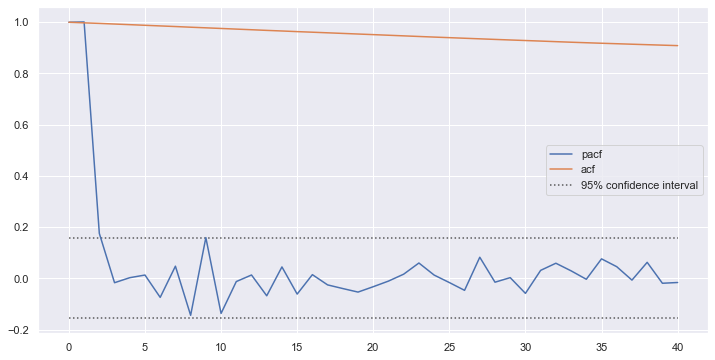

In [18]:
aapl_acf=acf(aapl_df['Close'].values, fft=True)
aapl_pacf=pacf(aapl_df['Close'].values, method='ols')

plt.figure(figsize=(12,6))
plt.plot(aapl_pacf, label='pacf')
plt.plot(aapl_acf, label='acf')
plt.hlines([1/np.sqrt(len(aapl_acf)), -1/np.sqrt(len(aapl_acf))],
           xmin=0, xmax=40, alpha=0.7,
           linestyles='dotted', label='95% confidence interval')
plt.legend()
plt.show()

### The current data point, $x_t$, is only dependent on the previous data point, with little to no statistical signifcant correlation between it and other data points.

### Due to the  independent nature of the data points and overall lack of patterns, such as seasonality, an LSTM would be quite useful for this dataset. First the data is scaled down to the range $(0, 1)$.

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
scaler=MinMaxScaler(feature_range=(0, 1))

### 80% of the data is used for training, with the remaining 20% used for testing.

In [21]:
train_size=int(len(aapl_df)*0.8)
test_size=len(aapl_df)-train_size

In [22]:
train_size, test_size, len(aapl_df)

(3133, 784, 3917)

In [23]:
train_data=np.array(aapl_df.iloc[0:train_size,0])
test_data=np.array(aapl_df.iloc[train_size:,0])

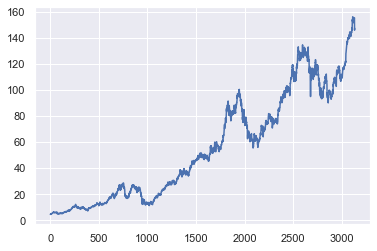

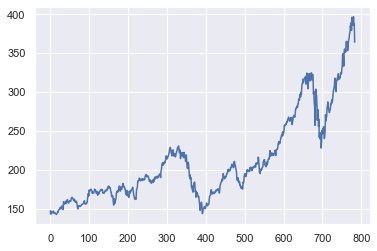

In [24]:
plt.plot(train_data)
plt.show()
plt.plot(test_data)
plt.show()

In [25]:
training_set_scaled = scaler.fit_transform(train_data.reshape(-1,1))
testing_set_scaled = scaler.fit_transform(test_data.reshape(-1,1))

In [26]:
X_train = []
y_train = []
for i in range(60, len(train_data)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [27]:
X_train.shape, y_train.shape

((3073, 60, 1), (3073,))

##### Creating the LSTM model

In [28]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense 

In [29]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train,
                    epochs=50, batch_size=30,
                    verbose=2, validation_split=0.1)

Epoch 1/50
93/93 - 5s - loss: 0.0098 - val_loss: 0.0066
Epoch 2/50
93/93 - 4s - loss: 0.0023 - val_loss: 0.0032
Epoch 3/50
93/93 - 5s - loss: 0.0020 - val_loss: 0.0054
Epoch 4/50
93/93 - 4s - loss: 0.0016 - val_loss: 0.0014
Epoch 5/50
93/93 - 4s - loss: 0.0017 - val_loss: 0.0012
Epoch 6/50
93/93 - 4s - loss: 0.0015 - val_loss: 0.0013
Epoch 7/50
93/93 - 4s - loss: 0.0014 - val_loss: 0.0031
Epoch 8/50
93/93 - 4s - loss: 0.0015 - val_loss: 0.0038
Epoch 9/50
93/93 - 4s - loss: 0.0014 - val_loss: 0.0011
Epoch 10/50
93/93 - 4s - loss: 0.0012 - val_loss: 0.0074
Epoch 11/50
93/93 - 4s - loss: 0.0014 - val_loss: 0.0012
Epoch 12/50
93/93 - 4s - loss: 0.0011 - val_loss: 0.0019
Epoch 13/50
93/93 - 4s - loss: 0.0011 - val_loss: 8.5633e-04
Epoch 14/50
93/93 - 4s - loss: 0.0012 - val_loss: 8.7690e-04
Epoch 15/50
93/93 - 4s - loss: 0.0012 - val_loss: 0.0017
Epoch 16/50
93/93 - 4s - loss: 0.0010 - val_loss: 0.0014
Epoch 17/50
93/93 - 5s - loss: 0.0011 - val_loss: 0.0020
Epoch 18/50
93/93 - 4s - loss: 0

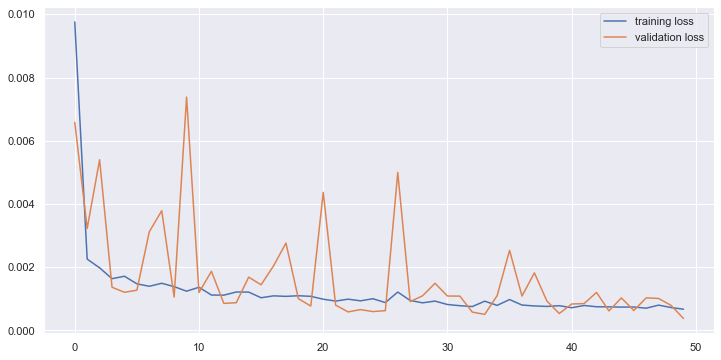

In [30]:
plt.figure(figsize=(12,6))
plt.plot(np.array(list(history.history.values()))[0])
plt.plot(np.array(list(history.history.values()))[1])
plt.legend(['training loss','validation loss'])
plt.show()

In [31]:
dataset_total = aapl_df.iloc[:,0]
inputs = dataset_total[len(dataset_total) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(len(test_data)):
    X_test.append(inputs[i:i+60, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [32]:
X_test.shape, predicted_stock_price.shape

((784, 60, 1), (784, 1))

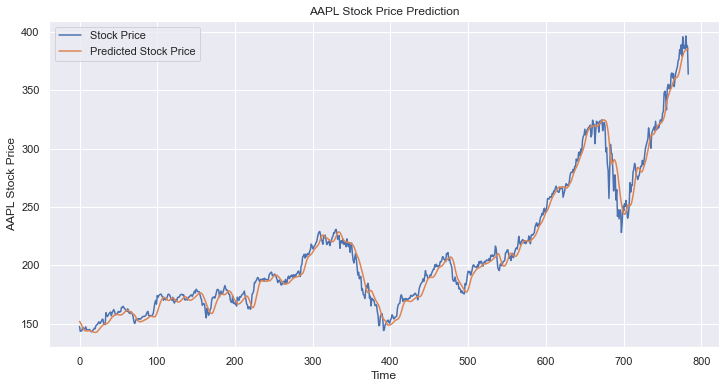

In [33]:
plt.figure(figsize=(12,6))
plt.plot(test_data, label = 'Stock Price')
plt.plot(predicted_stock_price, label = 'Predicted Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

### This same model is also used on the 7-day rolling average:

In [34]:
train_data_7=np.array(aapl_df.iloc[7:train_size,6])
test_data_7=np.array(aapl_df.iloc[train_size:,6])

In [35]:
training_set_scaled = scaler.fit_transform(train_data_7.reshape(-1,1))
testing_set_scaled = scaler.fit_transform(test_data_7.reshape(-1,1))

In [36]:
X_train = []
y_train = []
for i in range(60, len(train_data)-7):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [37]:
X_train.shape, y_train.shape

((3066, 60, 1), (3066,))

In [38]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history_7 = model.fit(X_train, y_train,
                    epochs=50, batch_size=30,
                    verbose=2, validation_split=0.1)

Epoch 1/50
92/92 - 5s - loss: 0.0101 - val_loss: 0.0046
Epoch 2/50
92/92 - 4s - loss: 0.0020 - val_loss: 0.0033
Epoch 3/50
92/92 - 4s - loss: 0.0018 - val_loss: 0.0018
Epoch 4/50
92/92 - 4s - loss: 0.0019 - val_loss: 0.0062
Epoch 5/50
92/92 - 4s - loss: 0.0016 - val_loss: 0.0023
Epoch 6/50
92/92 - 4s - loss: 0.0016 - val_loss: 0.0022
Epoch 7/50
92/92 - 4s - loss: 0.0016 - val_loss: 0.0018
Epoch 8/50
92/92 - 4s - loss: 0.0014 - val_loss: 0.0012
Epoch 9/50
92/92 - 4s - loss: 0.0013 - val_loss: 0.0018
Epoch 10/50
92/92 - 4s - loss: 0.0012 - val_loss: 0.0015
Epoch 11/50
92/92 - 4s - loss: 0.0015 - val_loss: 9.7039e-04
Epoch 12/50
92/92 - 4s - loss: 0.0011 - val_loss: 0.0029
Epoch 13/50
92/92 - 4s - loss: 0.0012 - val_loss: 0.0026
Epoch 14/50
92/92 - 4s - loss: 0.0011 - val_loss: 0.0024
Epoch 15/50
92/92 - 4s - loss: 0.0012 - val_loss: 0.0014
Epoch 16/50
92/92 - 4s - loss: 0.0010 - val_loss: 0.0025
Epoch 17/50
92/92 - 4s - loss: 9.6802e-04 - val_loss: 0.0010
Epoch 18/50
92/92 - 4s - loss: 0

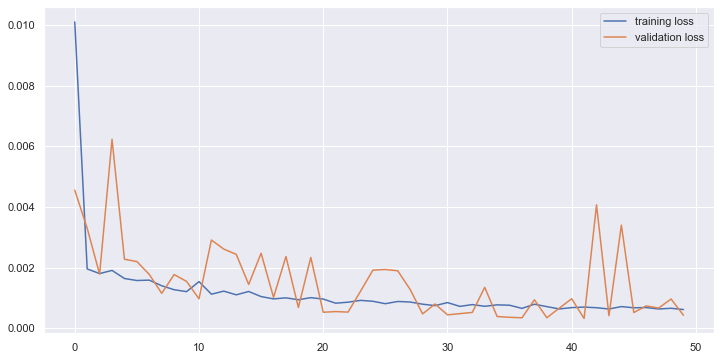

In [39]:
plt.figure(figsize=(12,6))
plt.plot(np.array(list(history_7.history.values()))[0])
plt.plot(np.array(list(history_7.history.values()))[1])
plt.legend(['training loss','validation loss'])
plt.show()

In [40]:
dataset_total = aapl_df.iloc[:,6]
inputs = dataset_total[len(dataset_total) - len(test_data_7) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(len(test_data)):
    X_test.append(inputs[i:i+60, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price_7 = model.predict(X_test)
predicted_stock_price_7 = scaler.inverse_transform(predicted_stock_price_7)

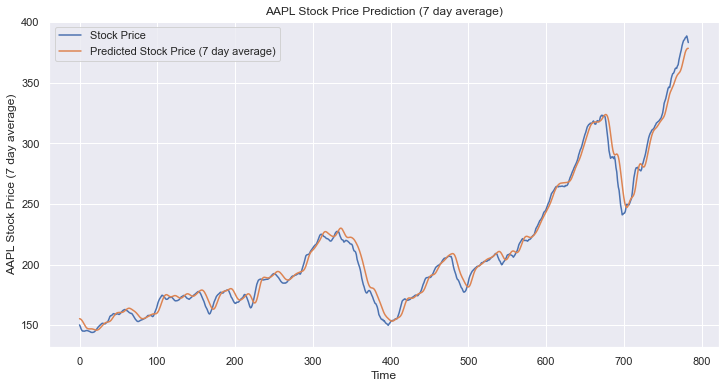

In [41]:
plt.figure(figsize=(12,6))
plt.plot(test_data_7, label = 'Stock Price')
plt.plot(predicted_stock_price_7, label = 'Predicted Stock Price (7 day average)')
plt.title('AAPL Stock Price Prediction (7 day average)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (7 day average)')
plt.legend()
plt.show()

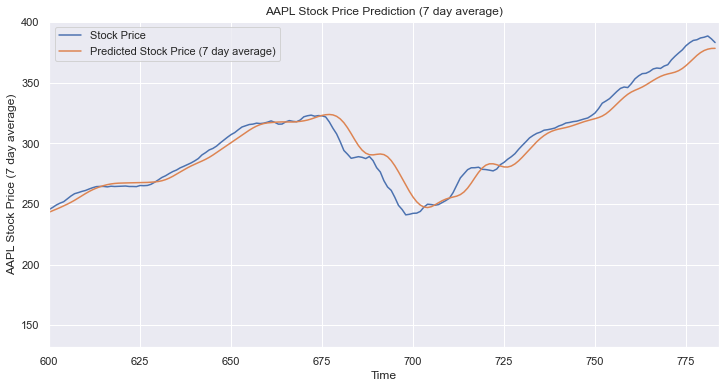

In [42]:
plt.figure(figsize=(12,6))
plt.plot(test_data_7, label = 'Stock Price')
plt.plot(predicted_stock_price_7, label = 'Predicted Stock Price (7 day average)')
plt.title('AAPL Stock Price Prediction (7 day average)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (7 day average)')
plt.xlim(600,len(test_data_7))
plt.legend()
plt.show()

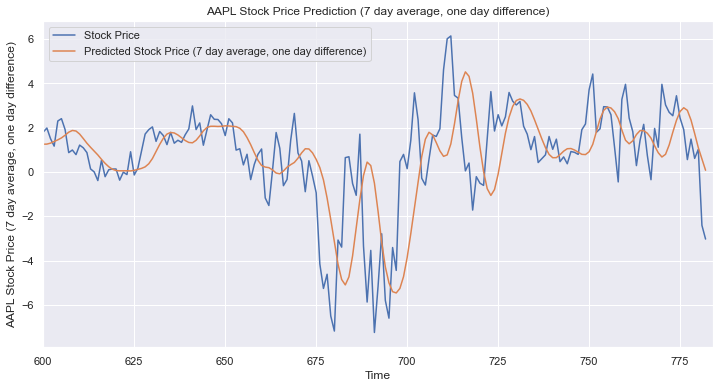

In [43]:
plt.figure(figsize=(12,6))
plt.plot(np.diff(test_data_7),
         label='Stock Price')
plt.plot(np.diff(predicted_stock_price_7, axis=0),
         label='Predicted Stock Price (7 day average, one day difference)')
plt.title('AAPL Stock Price Prediction (7 day average, one day difference)')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price (7 day average, one day difference)')
plt.xlim(600,len(test_data_7))
plt.legend()
plt.show()

### Adding signals for purchasing/selling stocks

In [44]:
signals = pd.DataFrame(index=aapl_df.index)
signals['signal'] = 0.0

In [45]:
signals['sma7']=aapl_df['sma7']
signals['sma30']=aapl_df['sma30']

In [46]:
signals['signal'][7:]=np.where(signals['sma7'][7:] > signals['sma30'][7:], 1, 0)

In [47]:
signals['position']=signals['signal'].diff()

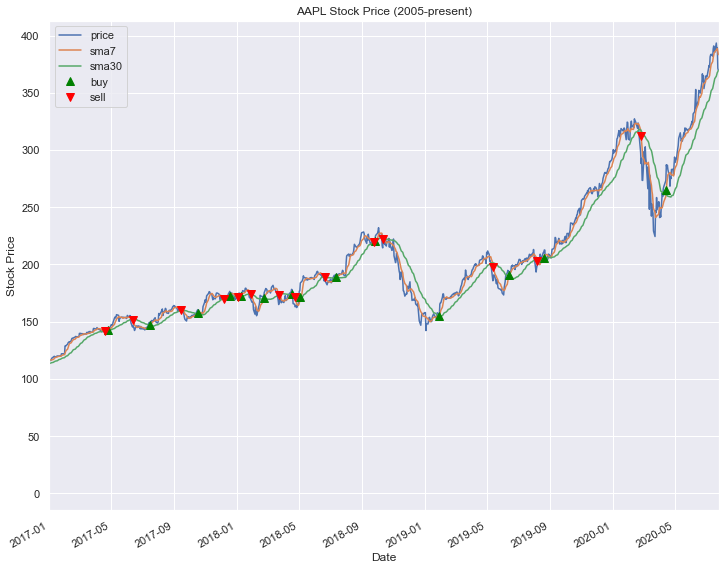

In [48]:
fig=plt.figure(figsize=(12,10))

ax1=fig.add_subplot(title="AAPL Stock Price (2005-present)", ylabel="Stock Price")
aapl_df['Close'].plot(ax=ax1, label='price')
aapl_df[['sma7', 'sma30']].plot(ax=ax1)

ax1.plot(signals.loc[signals['position']==1].index,
        signals['sma7'][signals['position']==1], '^', markersize=8, color='green', label='buy')
ax1.plot(signals.loc[signals['position']==-1].index,
        signals['sma7'][signals['position']==-1], 'v', markersize=8, color='red', label='sell')

plt.xlim(pd.Timestamp('2017-01-01'), pd.Timestamp.today())
plt.legend()

plt.show()